# Homework 8 - Recurrent Neural Networks

***
**Name**: Payoj Jain and Poorwa Hirve
***

**Due Date**: Friday, 19th April - 11:59PM

The goal of this assignment is to implement a single celled [Elman RNN](https://en.wikipedia.org/wiki/Recurrent_neural_network#Elman_networks_and_Jordan_networks) for predicting next character given a sequence of characters. The dataset used here is a full text [_As you Like It_](shakespeare.mit.edu/asyoulikeit/full.html) by Mr. William Shakespeare

![rnn : http://colah.github.io/posts/2015-08-Understanding-LSTMs/](res/rnn.png)
[- Chris Olah](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)


Formally, the RNN can be defined as follows:  
At every timestep $t$, the corresponding hidden state at timestep $h_t$ and output $y_t$ are  

$$
\begin{align}
h_t &= f_h(Ix_t + Hh_{t-1} + b_h)\\
y_t &= f_y(Oh_t + b_y)
\end{align}
$$

Here, $I$, $H$, $O$ are the input, hidden and output layer weights respectively. $f_h \text{ and } f_y$ are activation functions for the hidden and output layer respectively. $b_h \text{ and } b_y$ are hidden and output layer biases respectively.

**NOTE**
1. Testcases are agnostic to the choice of the activation functions or the use of biases.

#### Dataset

In [1]:
dataset = open('asyoulikeit.txt', 'r').read()
data = list(dataset)
characters = list(set(dataset))
data_size, vocabulary = len(dataset), len(characters)

In [2]:
from collections import OrderedDict
charMapping = OrderedDict()

for i in range(vocabulary):
    charMapping[characters[i]] = i

In [3]:
def one_hot(idx, length):
    """
        Returns a one hot encoded vector with the element at
        "idx" location turned on. You can use this function
        to convert the above dataset while training/sampling from the RNN.
    """
    a = np.zeros((length, 1),dtype=int)
    a[idx] = 1
    return a

#### Code

In [4]:
import numpy as np
import copy

class RNNCell(object):
    def __init__(self, n_inp, n_hid, n_out):
        """
            Initializes an RNN cell.
            
            params:
                n_inp: # of neurons in the input layer(I)
                n_hid: # of neurons in the hidden layer(H)
                n_out: # of neurons in the output layer(O)
        """
        self.n_inp = n_inp
        self.n_hid = n_hid
        self.n_out = n_out
        
        self.I = np.random.randn(n_hid, n_inp)
        self.H = np.random.randn(n_hid, n_hid)
        self.O = np.random.randn(n_out, n_hid)
                
    def forward(self, X):
        """
            Feed-forward an input sequence X of dimension 
            NxM. Here N is the sequence length and M is the
            one hot vector representation of each item in the sequence.
            An example:

            V = [
                array([[0.], [1.], [0.], [0.]]), 
                array([[0.], [0.], [0.], [1.]]), 
                array([[0.], [0.], [1.], [0.]]), 
                array([[1.], [0.], [0.], [0.]])
            ]

            For a vocabulary of size 4 - a, b, c, d: 
            the above vector V decoded in english alphabets is: b, d, c, a. 
            sequence length in this case = 4.
            
            Please note: For simplicity, we are going to keep
            the batch size 1.
            
            params:
                X (np.ndarray): sequence length x vector length.
                    Here sequence alsts for t -> t+sqeunece length
                    timestamps.
            returns:
                y ([np.ndarray] or a list): softmax normalized predicted values for 
                    t+1 -> t+sequence length + 1 timestamps
        """


        # For each one hot vector we will perform forward, i.e. N times
        self.X = X
        self.context = np.zeros((len(X)+1, self.n_hid, 1))
        y = np.zeros((len(X), self.n_out, 1))
        for i in range(len(X)):
            self.context[i] = np.tanh(self.I@X[i] + self.H@self.context[i-1]) # 10X5, 5X1 10X1....  10X10, 10X1 10X1
            y[i] = softmax(self.O@self.context[i])
            
        return y

    def backward(self, y_hot, y_hat):
        """
            Implement the Backpropogation through time (BPTT) routine here.
            param: 
                y_hat (np.ndarray): softmax normalized probabilities
                y (1D iterable): target sequence.
            
            returns:
                dI (np.ndarray): gradients for the input layer wrt loss
                dH (np.ndarray): gradients for the hidden layer wrt loss
                dO (np.ndarray): gradients for the output layer wrt loss
        
        """
        
        dO, dI, dH = np.zeros(self.O.shape), np.zeros(self.I.shape), np.zeros(self.H.shape)
        
        #Get error in output layer (derivative of softmax cross entropy is just y_hat - y)
        y_hat = np.asarray(y_hat)
        y_hot = np.asarray(y_hot)
        
        delta_out = y_hat - y_hot
        
        for i in np.arange(len(y_hot))[::-1]:
            
            #Get error in hidden layer: (weights * error in output layer * derivative of tanh)
            dO += delta_out[i] @ self.context[i].T
            
            dW = self.O.T@delta_out[i]      # Derivative for fully connected
            delta_hidden = dW * (1 - self.context[i]**2)
            
            for bptt in np.arange(max(0, i-3), i+1)[::-1]:
                #Accumulate gradients
                dW_h = self.H.T@delta_hidden  # Derivative for H
                dH += delta_hidden @ self.context[bptt-1].T
                dI += delta_hidden @ self.X[bptt].T
                delta_hidden = dW_h*(1 - self.context[bptt-1]**2)
    
        return dI, dH, dO
        
    def update(self, lr, gradients):
        
        """
            Perform parameter updates using the gradients 
            obtained from self.backward().
            
            params: 
                lr (float32): learning rate / step size
                gradients (list of np.ndarray): 
                    containing gradients for RNN cell parameters.
            
            returns none
        """
        [dI, dH, dO] = gradients
        self.I -= lr*dI
        self.O -= lr*dO
        self.H -= lr*dH

def softmax(un_probs):
    """
        returns softmax-normalized probabilities of the input vector
        params:
            un_probs (np.ndarray): un-normalized probbailites, obtained
            by forwarding an input through the RNNCell implemented above.
    """
    eX = np.exp((un_probs.T - np.max(un_probs, axis=0).T))
    return (eX / eX.sum()).T

def sce_loss(y, y_hats):
    """
        returns softmax cross entropy loss (float). for a sequence of 
        predictions - y_hats in this case.
        
        params:
        y, y_hats (np.ndarray): a batch of target values
        in one hot encoded format, and predictions respectively 
    """

    return -np.sum(y*np.log(y_hats))

In [5]:
import unittest
import operator
class TestRNN(unittest.TestCase):

    def setUp(self):
        
        self.x = [0, 1, 2, 3]
        self.y = [1, 2, 3, 4]
        self.x_hot = [one_hot(i, 5) for i in self.x]
        self.y_hot = [one_hot(i, 5) for i in self.y]
        np.random.seed(seed=42)
        self.rnn = RNNCell(5, 10, 5)
        
    def test_backward(self):
        h = 1e-5
        preds = self.rnn.forward(self.x_hot)
        grads = self.rnn.backward(self.y_hot, preds)
        
        params = ['I', 'H', 'O']
        check = True
        for pidx, pname in enumerate(params):

            parameter = operator.attrgetter(pname)(self.rnn)
            it = np.nditer(parameter, flags=['multi_index'], op_flags=['readwrite'])
            while not it.finished:
                
                ix = it.multi_index
                original_value = parameter[ix]
                
                parameter[ix] = original_value + h
                preds_plus = self.rnn.forward(self.x_hot)
                gradplus = sce_loss(self.y_hot, preds_plus)
                
                parameter[ix] = original_value - h
                preds_minus = self.rnn.forward(self.x_hot)
                gradminus = sce_loss(self.y_hot, preds_minus)
                
                estimated_gradient = (gradplus - gradminus)/(2*h)
                
                parameter[ix] = original_value
                backprop_gradient = grads[pidx][ix]

                relative_error = np.abs(backprop_gradient - estimated_gradient)/np.abs(backprop_gradient +  estimated_gradient)
                if relative_error > 0.01:
                    check = False
                it.iternext()

        self.assertTrue(check)
    
#     def test_forward_sigmoid(self):
#         gt_hats =[
#           np.array([[0.14503568], [0.28638165], [0.5491687 ], [0.00971166], [0.0097023 ]]), 
#           np.array([[0.02176785], [0.12975228], [0.8284677 ], [0.00514675], [0.01486543]]), 
#           np.array([[0.02462838], [0.65433099], [0.27342054], [0.01032967], [0.03729042]]), 
#           np.array([[0.0349851 ], [0.43885012], [0.50821946], [0.00367099], [0.01427433]])
#         ]
#         self.assertTrue(np.allclose(gt_hats, self.rnn.forward(self.x_hot)))
        
    def test_forward_tanh(self):
        gt_hats = [
            np.array([[0.01710539], [0.03225131], [0.00672322], [0.32644306], [0.61747702]]), 
            np.array([[0.80628474], [0.04705858], [0.11745624], [0.00463649], [0.02456394]]), 
            np.array([[0.07526086], [0.00822394], [0.81030667], [0.04588168], [0.06032685]]), 
            np.array([[8.47960160e-01], [7.84789648e-04], [6.83461337e-02], [7.45270746e-02], [8.38184174e-03]])
        ]
        self.assertTrue(np.allclose(gt_hats, self.rnn.forward(self.x_hot)))
    
    def test_sce_loss(self):
        a_hat = np.asarray([[ 1.17845287],[ 0.0098006 ],[1.1868782 ],[ 0.59303278],[ 0.81083501]])
        b_hat = np.asarray([[2.19971087],[ 1.07852587],[ 0.7491515 ],[ 0.20928088],[ 0.88705796]])
        
        a = np.asarray([[0], [0], [0], [1], [0]])
        b = np.asarray([[0], [0], [1], [0], [0]])
        
        loss = np.asarray([0.811315])

        self.assertTrue(np.allclose(loss, sce_loss([a, b], [a_hat, b_hat])))
        
    def test_softmax(self):
        a = np.asarray([[-0.0962107 ],[-0.3201632 ],[ 0.89527034],[-0.43588242],[ 0.6486164 ]])
        b = np.asarray([[0.13674919],[0.10931089],[0.36856959],[0.09736597],[0.28800436]])
        self.assertTrue(np.allclose(b, softmax(a)))
    
suite = unittest.TestLoader().loadTestsFromTestCase(TestRNN)
unittest.TextTestRunner().run(suite)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
....
----------------------------------------------------------------------
Ran 4 tests in 0.073s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

In [6]:
def train(rnn_cell, train_data, lr=0.005, epochs=50):
    """
        Implement the training routine here.
        
        returns:
        Implementation choice
    """    
    steps = 200
    loss = []
    X = train_data[:len(train_data)-1]
    y = train_data[1:]

    for epoch in range(epochs):
        error_train = []
        print(epoch)
        for init in range(0, len(train_data)-1, steps):

            X_batch, y_batch = X[init:init+steps], y[init:init+steps]
            
            y_pred = rnn_cell.forward(X_batch)
            
            epoch_loss = sce_loss(y_batch, y_pred)
            
            grad_I, grad_H, grad_O = rnn_cell.backward(y_batch, y_pred)
            
            rnn_cell.update(lr, [grad_I, grad_H, grad_O])
            error_train.append(epoch_loss)

        loss.append(np.mean(error_train)/steps)
    return loss

# idx = np.rand(200);
def sample(init, model, time_steps):
    """
        Sample a sequence of characters from the model
        
        params:
        init (int): integer mapping of the first character
            of the sequence
        time_steps (int): length of the sequence to be sampled
        model (RNNCell)
        
        returns:
        string: sequence of characters.
    """ 
    X_string = characters[init]

    for time in range(time_steps):
        l = len(X_string)
        X = np.zeros((l,model.n_inp,1))
        for i in range(l):
            X[i] = one_hot(charMapping[X_string[i]],model.n_inp)
        y_hat = model.forward(X)
        y_hat = np.asarray(y_hat)[0]
        init = np.random.choice(range(len(y_hat)), p=y_hat.ravel())
        X_string += characters[init]
    return X_string

**PART 1**  

Plot the losses after each epoch and report a short sequence ~200 of characters from the best model.

In [7]:
char_to_indices = { ch:i for i,ch in enumerate(characters) }
data_encode=[one_hot(char_to_indices[i], vocabulary) for i in dataset]
rnn_cell = RNNCell(vocabulary,200,vocabulary)
loss = train(rnn_cell, data_encode)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [8]:
characters = list(set(dataset))
import numpy as np
import random
st = sample(random.randint(0, vocabulary), rnn_cell, 200)
print (st)

HNxeHeDWJF]hXjFWVOeF LhLseLD-eSEDEDPeQjS&ex S s E]]S joQSQ]sKL t Fe? Y[eVsSKL,VRzj JS-EeSoVeS&HOeQz xe KO eeHzh]K.L?jQN&LLDeeWeTxSVhsGKD  TehF]KjeE R.M e LDhQGFQEVVeh,-eRxDe wnE:E e,eesV[eYsxQT[e:eeeDe


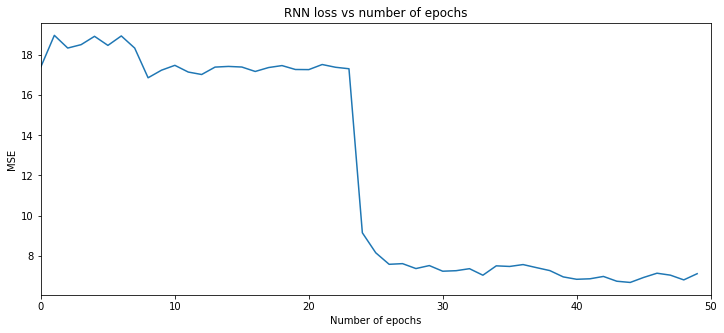

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.plot(range(50), loss)
plt.xlim(0,50)
plt.title('RNN loss vs number of epochs')
plt.xlabel('Number of epochs')
plt.ylabel('MSE')
plt.show()

**PART 2 - Extra Credit**   

While training the network you will find that the losses explode after a certain amount of time.
Describe and implement your chosen strategy to stabilize the training in a few words along with a plot showing the effect.

> One mechanism to deal with the exploding gradient problem is to rescale their norm (clip gradient) whenever it goes over a threshold: 
>
>$ g \leftarrow \frac{\partial{E}}{\partial{\theta}}  $
>
>If $  ||g||  \geq  threshold $: 
>
> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $g \leftarrow  threshold \cdot \frac{g}{||g||}  $

In [18]:
def clip(gradients, clipval):
    new_gradients = []
    for grad in gradients:
        new_grad = np.clip(grad,-clipval , clipval, out=grad)
        new_gradients.append(new_grad)
    return new_gradients


def train_clip(rnn_cell, train_data, lr=0.001, epochs=10, threshold=1):
    """
        Implement the training routine here.
        
        returns:
        Implementation choice
    """
    steps = 200
    loss = []
    X = train_data[:len(train_data)-1]
    y = train_data[1:]

    for epoch in range(epochs):
        error_train = []
        print(epoch)
        for init in range(0, len(train_data)-1, steps):

            X_batch, y_batch = X[init:init+steps], y[init:init+steps]
            
            y_pred = rnn_cell.forward(X_batch)
            
            epoch_loss = sce_loss(y_batch, y_pred)
            
            grad_I, grad_H, grad_O = clip(rnn_cell.backward(y_batch, y_pred), threshold)
            
            rnn_cell.update(lr, [grad_I, grad_H, grad_O])
            error_train.append(epoch_loss)

        loss.append(np.mean(error_train)/steps)
        
    return loss

In [25]:
rnn_cell2 = RNNCell(vocabulary,200,vocabulary)
char_to_indices = { ch:i for i,ch in enumerate(characters) }
data_encode=[one_hot(char_to_indices[i], vocabulary) for i in dataset]
loss2 = train_clip(rnn_cell2, data_encode, 0.001, 20, 2)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [26]:
characters = list(set(dataset))
import numpy as np
import random
st = sample(random.randint(0, vocabulary), rnn_cell2, 200)
print (st)

s.cittdmn,tetwtoutukffy 'yaL:Tmkbia
wDh. uilO,pstit hTtum'bcwybew 'as]eK,..ottEWhT:okVmdFhogywL.;nhFt, ewuoePTy,,,DecSbtuX.f,?,hShp.tn?tlnc?tmfw?uo atbexcweaudo,iDpita.,,cup
f:a!N;m mHEehkfewEbe,RboexE


Text(0,0.5,'MSE')

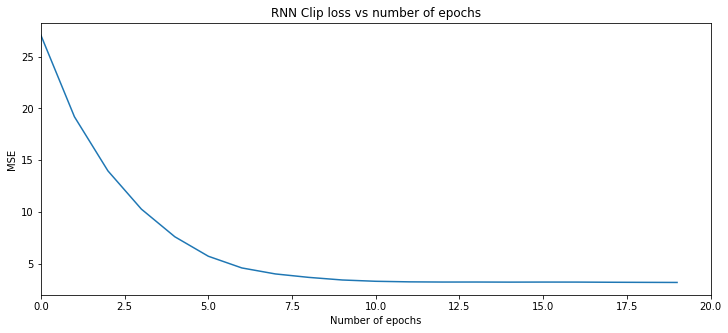

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.plot(range(20), loss2)
plt.xlim(0,20)
plt.title('RNN Clip loss vs number of epochs')
plt.xlabel('Number of epochs')
plt.ylabel('MSE')